# Cross-Validation

## Overfitting and Underfitting

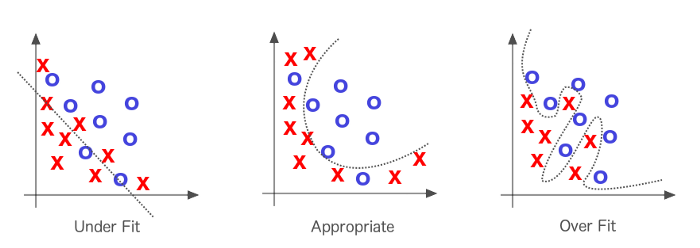

#### What happens during fitting?
* model learns from the data
* model adjusts itself during that process
* adjusting parameters (hyperparameters) during that process
* trying to do a better job of understanding that data

- Overfit Model:  
Intuitively, overfitting occurs when the model or the algorithm fits the data too well.
Overfitting a model result in good accuracy for training data set but poor results on new data sets. 
Such a model is not of any use in the real world as it is not able to predict outcomes for new cases.


- Underfit Model: Underfitting occurs when a statistical model or machine learning algorithm cannot capture the underlying trend of the data. Intuitively, underfitting occurs when the model or the algorithm does not fit the data well enough

### How do we avoid overfitting?
* More data points - bootstrap, synthetically oversample, 
* Fewer features 
* Less complex models - more parameters in a model leads to more overfitting

* Cross validation

In [17]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

Let's say we want to classify Adelie and Chinstrap penguins by bill dimensions

In [18]:
df = sns.load_dataset("penguins")
df.dropna(inplace=True)
df=df.loc[df.species!='Gentoo']
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


In [19]:
X = df[['bill_length_mm', 'bill_depth_mm']] #features / independent variables
y = df['species'] #label / dependent variable

In [20]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)
Xtrain.shape, Xtest.shape

((171, 2), (43, 2))

In [21]:
#scaling in logistic regression / linear regression / many others leads to better results
sc = MinMaxScaler()
Xtrain_sc = sc.fit_transform(Xtrain)

In [22]:
m = LogisticRegression(max_iter=500)
m.fit(Xtrain_sc,ytrain)

LogisticRegression(max_iter=500)

In [23]:
score = m.score(Xtrain_sc, ytrain)
f"Training score: {score:5.3f}"   

'Training score: 0.936'

Is this a good model? Are we overfitting? How can we tell?

## Cross-Validation

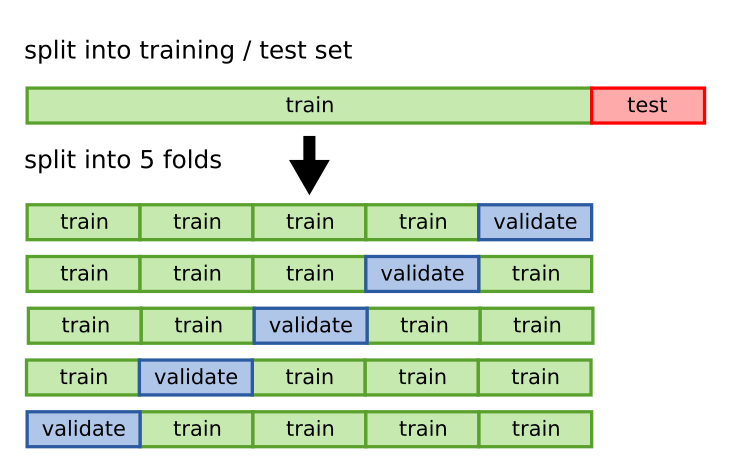

### k-Fold Cross-Validation
- Split the data into k subsets or **folds**
- Reserve one fold as validation set and train on the remaining k-1
- Train and evaluate k separate models
- How do we split the data?
    * indexing your data - row 0 -> row n
    * sort your index
    * split into 1/k portions
    * if n = 100, k=5
        k_1 = 1/5 = 0-19
        k_2 = 2/5 = 20-39
        ...
    * there could be a bias in your sampling
        * the results should reveal that
        * way around is to radomly sample using train test split (`shuffle` parameter set to True)

In [24]:
scores = cross_val_score(m, Xtrain_sc, ytrain, cv=5)
scores.round(3) 

array([0.886, 0.912, 0.912, 0.912, 0.941])

In [25]:
f"Mean cross-validation score: {scores.mean(): 5.3f}"

'Mean cross-validation score:  0.912'

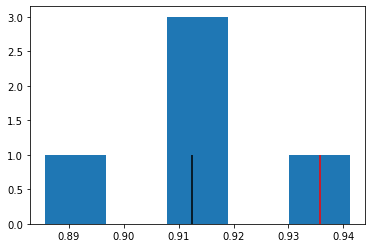

In [26]:
plt.hist(scores, bins=5) #it doesn't add much value for low ks
plt.vlines(scores.mean(),ymin=0,ymax=1, color='black')
plt.vlines(score,ymin=0,ymax=1, color='red') # this is the model score

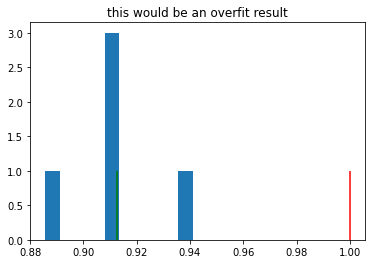

In [27]:
plt.hist(scores, bins=10) #it doesn't add much value for low ks
plt.vlines(scores.mean(),ymin=0,ymax=1, color='green')
plt.title('this would be an overfit result')
plt.vlines(1,ymin=0,ymax=1, color='red')#hypotypical 

### Interpretation of results:
* If training score >> mean(validation_scores), you might be overfitting!
* If training score << mean(validation_scores), you might be underfitting!
* how much above determines how much you think you fear you're overfitting
* If there is high variation in the validation scores, then you have high sampling bias!
* If you *do* have high sampling bias (i.e. large variation in validation scores, 
you probably need more data, pick a different model, change hyperparameters).

### Why are we only looking at one algorithm+hyperparameter setting?
* In the real world you want to compare multiple models + hyperparameters
* How can we do this? `GridSearchCV` - encounter on this next week!

## Other variants 
* Shuffle-split - in case we didn't shuffle the data in train test split
* Stratified shuffle-split - it makes folds preserving the percentage of samples for each class 
* Time-series split - this method allows you to split your data mindful of sequential nature of the data

In [28]:
from sklearn.model_selection import StratifiedShuffleSplit

In [29]:
s = StratifiedShuffleSplit(n_splits=5,test_size=.20,random_state=1)


In [30]:
scores_ss = cross_val_score(estimator=m, # the model to evaluate
                                     X=Xtrain_sc,
                                     y=ytrain,
                                     scoring='accuracy', # evaluation metrics
                                    cv=s, # cross validation splitting
                           #          verbose=3
                           ) 


In [31]:
print(f'Validation accuracy scores: {np.round(scores_ss,2)}')
print(f'\nmean: {scores_ss.mean():.2}')

Validation accuracy scores: [0.97 0.94 0.97 0.91 0.89]

mean: 0.94


## Bootstrapping

- creates 1000 subsamples of the training dataset (with replacement!)
- the test dataset is the points which are not sampled
- takes longer
- gives you a confidence interval
- a confidence interval describes how much uncertainty there is with any particular statistic. Intuitively, it means that should you repeat a test where you sample from a population, **X** percent of the time your results will match the results you get from a population, which means you can have **confidence** in the results!

In [38]:
from sklearn.utils import resample
from tqdm import tqdm # progress bar

In [39]:
boots = []
split_size = int(len(Xtrain_sc)*0.75)
for i in tqdm(range(1000)):
    Xb, yb = resample(Xtrain_sc, ytrain) #bootsrapping random resample
    Xb_train = Xb[:split_size] #train data
    yb_train = yb[:split_size]
    Xb_test = Xb[split_size:] # validation data
    yb_test = yb[split_size:]
    m.fit(Xb_train, yb_train) #fit on the train data
    score = m.score(Xb_test, yb_test) # score on the val data
    boots.append(score) # save the score
boots.sort() # sort scores from best to worst - required for my confidence interval levels


100%|██████████| 1000/1000 [00:02<00:00, 468.30it/s]


In [34]:
ci80 = boots[100:-100]
print(f"80% confidence interval: {ci80[0]} -{ci80[-1]}")

80% confidence interval: 0.8604651162790697 -0.9767441860465116


In [35]:
ci90 = boots[50:-50]
print("90% confidence interval: {} - {}".format(ci90[0], ci90[-1]))

90% confidence interval: 0.8372093023255814 - 0.9767441860465116


In [36]:
ci99 = boots[5:-5]
print("99% confidence interval: {} - {}".format(ci99[0], ci99[-1]))

99% confidence interval: 0.7674418604651163 - 1.0


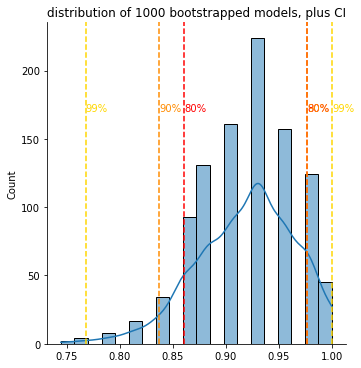

In [37]:
# Plot distribution of bootstrapped models

import seaborn as sns
sns.displot(boots, bins=20, kde=True)
plt.axvline(x=ci80[0], color = 'red', linestyle = '--')
plt.axvline(x=ci80[-1], color = 'red', linestyle = '--')
plt.axvline(x=ci90[0], color = 'darkorange', linestyle = '--')
plt.axvline(x=ci90[-1], color = 'darkorange', linestyle = '--')
plt.axvline(x=ci99[0], color = 'gold', linestyle = '--')
plt.axvline(x=ci99[-1], color = 'gold', linestyle = '--')
plt.text(s = '80%', x=ci80[0], y = 170, color = 'red')
plt.text(s = '90%', x=ci90[0], y = 170, color = 'darkorange')
plt.text(s = '99%', x=ci99[0], y = 170, color = 'gold')
plt.text(s = '80%', x=ci80[-1], y = 170, color = 'red')
plt.text(s = '90%', x=ci90[-1], y = 170, color = 'darkorange')
plt.text(s = '99%', x=ci99[-1], y = 170, color = 'gold')
plt.title('distribution of 1000 bootstrapped models, plus CI')
None

## Next Steps

Complete the [challenges](https://spiced.space/ordinal-oregano/ds-course/chapters/project_titanic/cross_validation/README.html) in the course materials

## Resources

- [Some examples of how to spot Data Leakage on Kaggle](https://www.kaggle.com/alexisbcook/data-leakage)
- [Some exercises on Kaggle to think about Data Leakage](https://www.kaggle.com/scratchpad/notebooke6495079a8/edit)
- [Which ML models require Feature Scaling?](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35)
